# USDC Usage
Using `sacct` to get the consumed energy of a the `lz` account.

In [2]:
import subprocess
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np

In [3]:
def convert_string_to_float(s: str) -> float:
    """
    This function converts a string to a float.

    Parameters
    ----------
    s : str
        The string to be converted. It can optionally end with 'M' or 'K' to indicate millions or thousands, respectively.

    Returns
    -------
    float
        The converted float value. If the conversion fails, it prints the string and 'failed' and returns 0.0.
    """
    s = s.strip()  # Remove leading and trailing spaces
    try:
        if s[-1] == 'M':
            return float(s[:-1]) * 1e6
        elif s[-1] == 'K':
            return float(s[:-1]) * 1e3
        else:
            return float(s)
    except:
        # print(f'failed to read string={s}') # happens too much
        return 0.0

In [4]:
def get_account_usage(account_name: str, start_year: int = 2021) -> dict:
    """
    This function retrieves the account usage data for a given account name and start year.

    Parameters
    ----------
    account_name: str
        The name of the account for which usage data is to be retrieved.
    start_year: int, optional
        The year from which to start retrieving usage data. Defaults to 2021.

    Returns
    -------
    dict 
        A dictionary containing the usage data for each month, starting from the specified start year.
        The keys are the start dates of the months in the format "YYYY-MM-DD", and the values are the total
        consumed energy for that month. If there is an error running the sacct command, the value for that
        month is set to 0.0.
    """
    values = {}

    for year in tqdm.tqdm(range(start_year, datetime.now().year + 1)):
        for month in range(1, 13):
            start_date = f"{year}-{month:02d}-01"
            if month == 12:
                end_date = f"{year+1}-01-01"
            else:
                end_date = f"{year}-{month+1:02d}-01"

            command = ["sacct",
                       f"--starttime={start_date}", 
                       f"--endtime={end_date}", 
                       "--account=lz",
                       "--format=ConsumedEnergy"]

            result = subprocess.run(command, capture_output=True, text=True)
            if result.returncode == 0:
                month_info = result.stdout.split('\n')[2:]
                if len(month_info) > 1:
                    month_total = [convert_string_to_float(r) for r in month_info if len(r) > 0]
                else:
                    month_total = [0.0]
                values[start_date] = sum(month_total)
            else:
                print("Error running sreport:", result.stderr)
                values[start_date] = 0.0
    return values

In [ ]:
monthly_usage = get_account_usage("lz")

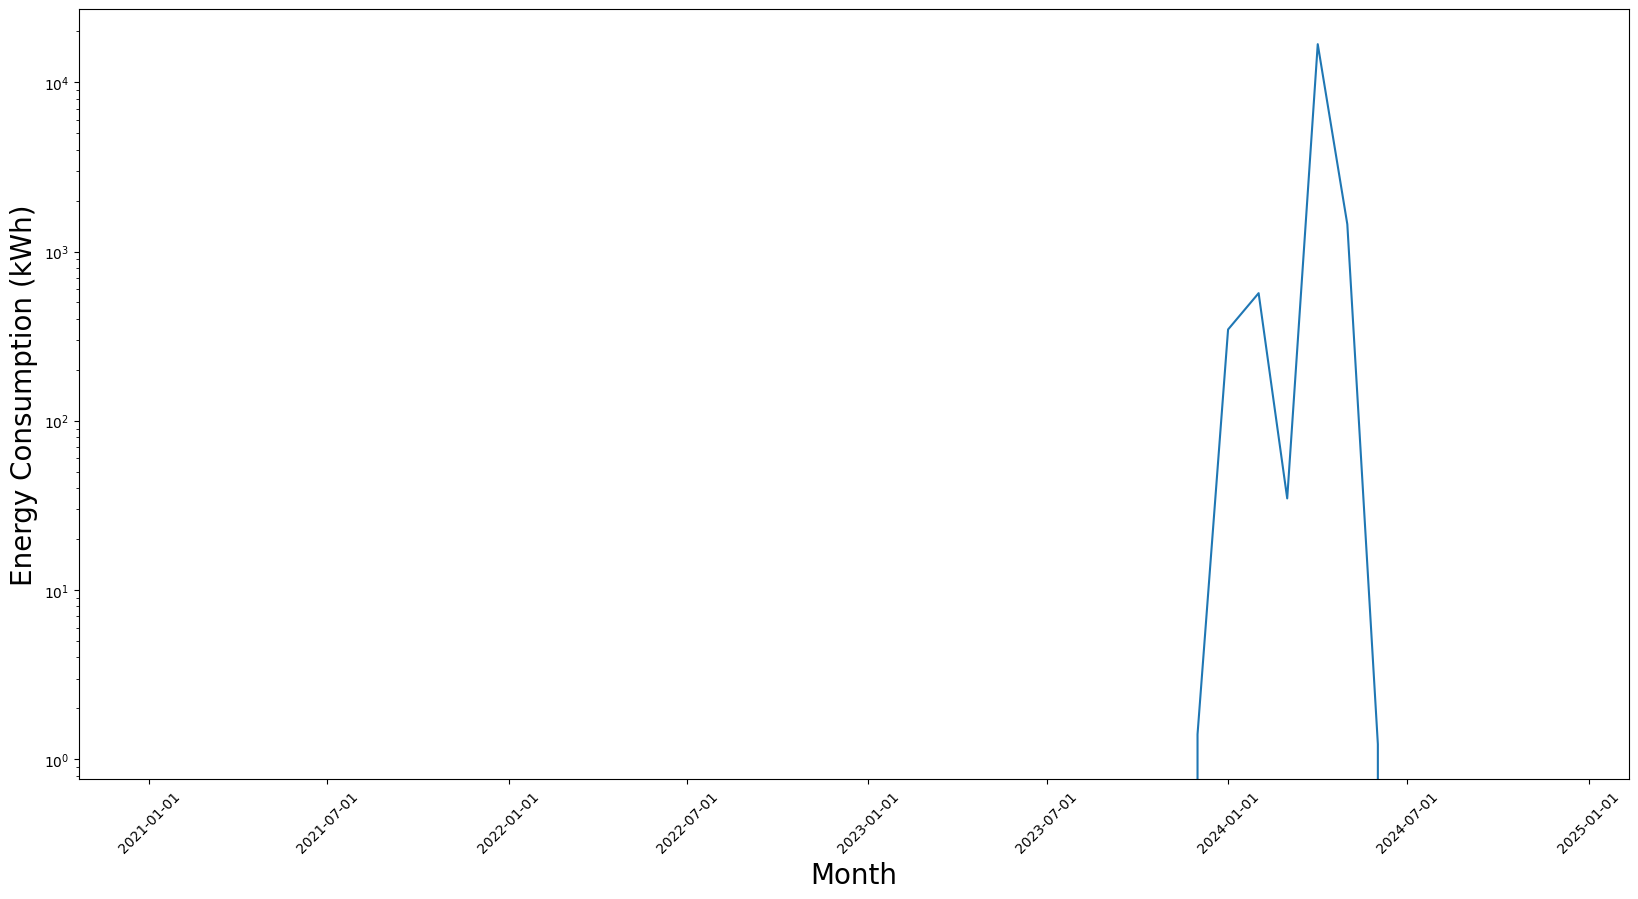

In [6]:
dates = np.array([datetime.strptime(date, "%Y-%m-%d") for date in monthly_usage.keys()])
values = np.array([monthly_usage[key] for key in monthly_usage.keys()])
to_kwh = 0.0000002777777

fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(dates, values * to_kwh)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.set_yscale('log')
ax.set_ylabel('Energy Consumption (kWh)', fontsize=20)
ax.set_xlabel('Month', fontsize=20)
plt.xticks(rotation=45)
plt.show()